In [ ]:
# 用單個模型同時執行兩個分類任務:
#   age 分成8個classes
#   gender 分成2個classes
# mlp 每個全連接層的unit個數: 512 - 128 -- 8
#                   
# trainning: 
#   改用generator產生資料給fit_generator
#   class_weight
#   random_state
#   callback: EarlyStop, model.save

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
DROP_RATE = 0.4

#model_folder_path = 'drive/My Drive/Tibame_AIoT_Project/face'
#model_folder_path = 'drive/My Drive/Tibame_AIoT_Project'
model_folder_path = 'models'
CLEAN_AUG_DATA = 0
if CLEAN_AUG_DATA == 1:
    img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/cleandataset'
else:
    #img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki'
    img_folder_path = 'D:\\user\\PycharmProjects\\processed-imdb-wiki-dataset'

FULL_DATA = 1 #用全部資料
#FULL_DATA = 0 

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# # to measure execution time
# !pip install ipython-autotime
# %load_ext autotime

In [2]:
! nvidia-smi

Mon Oct 26 14:49:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0    N/A /  N/A |     64MiB /  2048MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [7]:
# !pip install mtcnn

In [8]:
# !pip install tensorflow==2.2.0

In [4]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
#import keras
#from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, LeakyReLU
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l1,l2,l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN
import numpy as np

In [5]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


In [6]:
if CLEAN_AUG_DATA == 1:
    # cleandata: 清除wiki資料集原本的一些年齡標註錯誤, 並擴增10歲以下與70歲以上的資料
    df = pd.read_csv(os.path.join(img_folder_path, 'cleandata.csv'))
else:
    # 資料集由csv檔案讀入, 也可新增其他的csv檔案來擴充資料
    # df = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_wiki.csv')
    # df_under10 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_under10.csv')
    # df_over70 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_over70.csv')
    df = pd.read_csv(os.path.join(img_folder_path, 'age_gender_wiki.csv'))
    df_under10 = pd.read_csv(os.path.join(img_folder_path, 'age_gender_imdb_under10.csv'))
    df_over70 = pd.read_csv(os.path.join(img_folder_path, 'age_gender_imdb_over70.csv'))
    df = pd.concat([df, df_under10, df_over70])

In [7]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]


In [8]:
# 每10歲分一類,70歲以上歸為同一類,共8類
df['age_grp'] = pd.cut(df['age'], bins=[0,10,20,30,40,50,60,70,110], right=False)
le = LabelEncoder()
le.fit(df['age_grp'].astype('str'))
df['age_cls'] = le.transform(df['age_grp'].astype('str'))
df

,full_path,gender,age,age_grp,age_cls
0,wiki_crop/17/10000217_1981-05-05_2009.jpg,1,27,"[20, 30)",2
1,wiki_crop/12/100012_1948-07-03_2008.jpg,1,59,"[50, 60)",5
2,wiki_crop/16/10002116_1971-05-31_2012.jpg,0,40,"[40, 50)",4
3,wiki_crop/02/10002702_1960-11-09_2012.jpg,0,51,"[50, 60)",5
4,wiki_crop/41/10003541_1937-09-27_1971.jpg,1,33,"[30, 40)",3
...,...,...,...,...,...
2268,imdb_crop/78/nm0498278_rm974293248_1922-12-28_...,1,86,"[70, 110)",7
2269,imdb_crop/19/nm0694619_rm3523791616_1942-11-2_...,0,71,"[70, 110)",7
2270,imdb_crop/19/nm0694619_rm3574123264_1942-11-2_...,0,71,"[70, 110)",7
2271,imdb_crop/56/nm0792556_rm551744512_1928-6-12_2...,1,86,"[70, 110)",7


In [9]:
df['age_cls'].value_counts().sort_index()

0      877
1     2125
2    11411
3     6625
4     4681
5     3420
6     2174
7     3975
Name: age_cls, dtype: int64

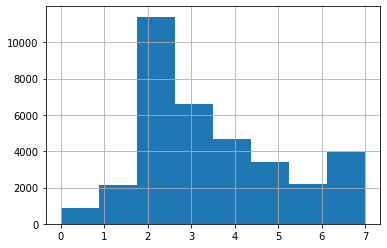

In [10]:
histogram_age = df['age_cls'].hist(bins=df['age_cls'].nunique())

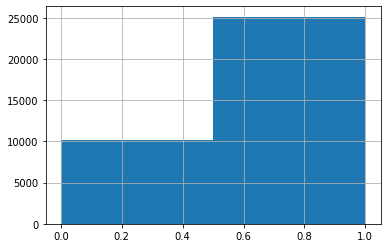

In [11]:
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [12]:
s = df.groupby(['gender'])['age_grp'].value_counts()
print(s.index)
print(s.values)
cls_cnt = s.sort_index()
cls_cnt

MultiIndex([(0,  [20, 30)),
            (0,  [30, 40)),
            (0,  [40, 50)),
            (0, [70, 110)),
            (0,  [10, 20)),
            (0,  [50, 60)),
            (0,   [0, 10)),
            (0,  [60, 70)),
            (1,  [20, 30)),
            (1,  [30, 40)),
            (1,  [40, 50)),
            (1, [70, 110)),
            (1,  [50, 60)),
            (1,  [60, 70)),
            (1,  [10, 20)),
            (1,   [0, 10))],
           names=['gender', 'age_grp'])
[3527 1934 1116 1016  940  698  513  403 7884 4691 3565 2959 2722 1771
 1185  364]


gender  age_grp  
0       [0, 10)       513
        [10, 20)      940
        [20, 30)     3527
        [30, 40)     1934
        [40, 50)     1116
        [50, 60)      698
        [60, 70)      403
        [70, 110)    1016
1       [0, 10)       364
        [10, 20)     1185
        [20, 30)     7884
        [30, 40)     4691
        [40, 50)     3565
        [50, 60)     2722
        [60, 70)     1771
        [70, 110)    2959
Name: age_grp, dtype: int64

In [13]:
np.array(cls_cnt)

array([ 513,  940, 3527, 1934, 1116,  698,  403, 1016,  364, 1185, 7884,
       4691, 3565, 2722, 1771, 2959], dtype=int64)

In [14]:
per_cls_eval = 100

if FULL_DATA == 0:
    #因資料不平均, 且多輸出分類器不能用class_weight, 所以只用部分資料來訓練
    per_cls_trn = 20 #100
    # class:  f0  f1  f2   f3  f4  f5   f6  f7  m0  m1  m2   m3   m4   m5   m6   m7
    # start_idx = [0, 600, 600, 600, 0, 600, 600, 0, 0, 600, 600, 600, 600, 600, 600, 600]
    start_idx = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    end_idx = np.array(start_idx) + per_cls_trn
    print(start_idx, end_idx)
else:
    # 資料量大, 分成幾群分別訓練(data_bunch_idx = 0 ~ data_bunch-1)
    data_bunch = 8
    data_bunch_idx = 0       

    per_cls_trn = (np.array(cls_cnt) - per_cls_eval) // data_bunch
    start_idx = np.zeros(16, dtype=int) + per_cls_trn * data_bunch_idx
    end_idx = start_idx + per_cls_trn


print(per_cls_trn)
print(start_idx)
print(end_idx)

[ 51 105 428 229 127  74  37 114  33 135 973 573 433 327 208 357]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 51 105 428 229 127  74  37 114  33 135 973 573 433 327 208 357]


In [15]:
#先用少量資料比較不同模型:
#每個類別各取部分資料,用train_test_split來切train and test
df_f0 = df[(df['age_cls'] == 0) & (df['gender'] == 0)]
df_f1 = df[(df['age_cls'] == 1) & (df['gender'] == 0)]
df_f2 = df[(df['age_cls'] == 2) & (df['gender'] == 0)]
df_f3 = df[(df['age_cls'] == 3) & (df['gender'] == 0)]
df_f4 = df[(df['age_cls'] == 4) & (df['gender'] == 0)]
df_f5 = df[(df['age_cls'] == 5) & (df['gender'] == 0)]
df_f6 = df[(df['age_cls'] == 6) & (df['gender'] == 0)]
df_f7 = df[(df['age_cls'] == 7) & (df['gender'] == 0)]
df_m0 = df[(df['age_cls'] == 0) & (df['gender'] == 1)]
df_m1 = df[(df['age_cls'] == 1) & (df['gender'] == 1)]
df_m2 = df[(df['age_cls'] == 2) & (df['gender'] == 1)]
df_m3 = df[(df['age_cls'] == 3) & (df['gender'] == 1)]
df_m4 = df[(df['age_cls'] == 4) & (df['gender'] == 1)]
df_m5 = df[(df['age_cls'] == 5) & (df['gender'] == 1)]
df_m6 = df[(df['age_cls'] == 6) & (df['gender'] == 1)]
df_m7 = df[(df['age_cls'] == 7) & (df['gender'] == 1)]

# train and val data
train_df = pd.concat([
    df_f0[start_idx[0]:end_idx[0]], df_f1[start_idx[1]:end_idx[1]], df_f2[start_idx[2]:end_idx[2]], df_f3[start_idx[3]:end_idx[3]], 
    df_f4[start_idx[4]:end_idx[4]], df_f5[start_idx[5]:end_idx[5]], df_f6[start_idx[6]:end_idx[6]], df_f7[start_idx[7]:end_idx[7]], 
    df_m0[start_idx[8]:end_idx[8]], df_m1[start_idx[9]:end_idx[9]], df_m2[start_idx[10]:end_idx[10]], df_m3[start_idx[11]:end_idx[11]], 
    df_m4[start_idx[12]:end_idx[12]], df_m5[start_idx[13]:end_idx[13]], df_m6[start_idx[14]:end_idx[14]], df_m7[start_idx[15]:end_idx[15]]         
    ])
"""
if FULL_DATA == 1:
    每個類別保留最後per_cls_eval筆資料作為evaluate用
    train_df = pd.concat([
        df_f0[:-per_cls_eval], df_f1[:-per_cls_eval], df_f2[:-per_cls_eval], df_f3[:-per_cls_eval], 
        df_f4[:-per_cls_eval], df_f5[:-per_cls_eval], df_f6[:-per_cls_eval], df_f7[:-per_cls_eval], 
        df_m0[:-per_cls_eval], df_m1[:-per_cls_eval], df_m2[:-per_cls_eval], df_m3[:-per_cls_eval], 
        df_m4[:-per_cls_eval], df_m5[:-per_cls_eval], df_m6[:-per_cls_eval], df_m7[:-per_cls_eval]         
        ])   


    #模擬imbalance data
    # train_df = pd.concat([
    #     df_f0[:10], df_f1[:20], df_f2[:30], df_f3[:40], 
    #     df_f4[:40], df_f5[:30], df_f6[:20], df_f7[:10], 
    #     df_m0[:10], df_m1[:20], df_m2[:30], df_m3[:40], 
    #     df_m4[:40], df_m5[:30], df_m6[:20], df_m7[:10]         
    #     ])            
else:    
    #每個類別取同樣數量的資料來訓練
    train_df = pd.concat([
        df_f0[start_idx[0]:end_idx[0]], df_f1[start_idx[1]:end_idx[1]], df_f2[start_idx[2]:end_idx[2]], df_f3[start_idx[3]:end_idx[3]], 
        df_f4[start_idx[4]:end_idx[4]], df_f5[start_idx[5]:end_idx[5]], df_f6[start_idx[6]:end_idx[6]], df_f7[start_idx[7]:end_idx[7]], 
        df_m0[start_idx[8]:end_idx[8]], df_m1[start_idx[9]:end_idx[9]], df_m2[start_idx[10]:end_idx[10]], df_m3[start_idx[11]:end_idx[11]], 
        df_m4[start_idx[12]:end_idx[12]], df_m5[start_idx[13]:end_idx[13]], df_m6[start_idx[14]:end_idx[14]], df_m7[start_idx[15]:end_idx[15]]         
        ])
"""
    
# evaluate data: 每個類別保留最後per_cls_eval筆資料作為evaluate用
eval_df = pd.concat([
        df_f0[-per_cls_eval:], df_f1[-per_cls_eval:], df_f2[-per_cls_eval:], df_f3[-per_cls_eval:], 
        df_f4[-per_cls_eval:], df_f5[-per_cls_eval:], df_f6[-per_cls_eval:], df_f7[-per_cls_eval:],
        df_m0[-per_cls_eval:], df_m1[-per_cls_eval:], df_m2[-per_cls_eval:], df_m3[-per_cls_eval:], 
        df_m4[-per_cls_eval:], df_m5[-per_cls_eval:], df_m6[-per_cls_eval:], df_m7[-per_cls_eval:]         
        ])
x_eval = np.array(eval_df['full_path'])
# 先把模型的兩個輸出的答案合併
y_eval = np.array(pd.concat([eval_df['age_cls'], eval_df['gender']], axis=1))
print("train:", len(train_df), "predict:", len(eval_df))

train: 4204 predict: 1600


In [16]:
# 處理答案 把它轉成one-hot (後面再做)
# y_train_category = to_categorical(df['age_cls'], num_classes=8)

# 2個輸出: age, gender
y_df = pd.concat([pd.DataFrame(train_df['age_cls']), pd.DataFrame(train_df['gender'])], axis=1)
#y_df = pd.DataFrame(train_df['age_cls'])

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df['full_path']), np.array(y_df), test_size=0.2, random_state=0)

print(x_train[0], x_test[0], y_train[0], y_test[0])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

wiki_crop/68/1403768_1970-11-09_2006.jpg wiki_crop/26/810826_1941-07-28_2015.jpg [3 0] [7 1]
(3363,) (841,) (3363, 2) (841, 2)


In [17]:
detector = MTCNN()
#feature_extractor = load_model(os.path.join(model_folder_path, 'facenet_keras.h5'))

In [18]:
# VGGFace: https://github.com/rcmalli/keras-vggface
#!pip install keras_vggface
#!pip install keras_applications

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
feature_extractor = VGGFace(model='resnet50', include_top=False, 
            input_shape=(224, 224, 3), pooling='avg')

In [19]:
feature_extractor.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [20]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
# x = Flatten()(x)

if DROP_RATE != 0:
    x = Dropout(DROP_RATE)(x)
x = Dense(units=512, kernel_regularizer='l1_l2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

if DROP_RATE != 0:
    x = Dropout(DROP_RATE)(x)
x = Dense(units=128, kernel_regularizer='l1_l2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

if DROP_RATE != 0:
    x = Dropout(DROP_RATE)(x)
age = Dense(units=8, activation='softmax', name='age', kernel_regularizer='l1_l2')(x)
#gender = Dense(units=2, activation='softmax', name='gender', kernel_regularizer='l1_l2')(x)

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# 2個輸出: age, gender
# age_gender_model = Model(inputs=feature_extractor.input, outputs=[age, gender])   
# age_gender_model.summary()

# 1個輸出: age
age_model = Model(inputs=feature_extractor.input, outputs=[age])   
age_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [21]:
# from keras.utils import plot_model
# plot_model(age_model, show_shapes=True)

In [22]:
age_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy') # 1個輸出: age

#age_model = load_model(os.path.join(model_folder_path,'03-5_resnet_mlp512-128_bs32_ep5_0.4468.h5'))

In [23]:
# # 資料預處理 for facenet?
# # Standardization
# def preprocess(imgs): 
#     for i in range(imgs.shape[0]):
#         # standardization
#         img = imgs[i]
#         mean, std = img.mean(), img.std()
#         img = (img - mean) / std
#         imgs[i] = img
#     return imgs
# # Normalization
# def normalize(img):
#     return img / 255.

# # -1 <= x <= 1
# def preprocess_1(imgs):
#     x = np.array(imgs, dtype = float)
#     x /= 127.5
#     x -= 1.
#     return x    

In [24]:
# 在 DataGenerator 做 real time 資料擴增
import imgaug.augmenters as iaa
import imgaug as ia
# augmentation
seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    #iaa.Flipud(0.5),
    iaa.Affine(
        scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},
        rotate=(-15, 15),
        # mode=ia.ALL, # edge, reflect, symmetric, warp, constant
        # shear=(-16,16)
    )
])

In [25]:
# detect face
def detect_faces(img):
    face_imgs = []

    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
     
    return face_imgs

In [26]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    """
    Generates data for Keras
    ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self,
                 paths,
                 y_cls,
                 batch_size,
                 #num_classes,
                 shuffle=False,
                 augment=False):
        self.paths = paths
        self.y_cls = y_cls
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        #self.num_classes = num_classes
        self.indexes = np.arange(len(self.paths))
        #self.class_map = {'0':0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        batch_y = [self.y_cls[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_paths, batch_y)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, paths, y_cls):
        """
        Generates data containing batch_size samples
        """
        # X = np.empty((len(paths), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
        # y = np.empty((len(paths), self.num_classes), dtype=np.float32)

        x_ori, x_norm, y_age, y_gender = [], [], [], []

        for i, path in enumerate(paths):
            #print("idx:", i, "cls:", y_cls[i], path)
        
            # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
            try:          
                img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
            except:
                print('imread failed:', path)
                continue 

            if self.augment:
                img_aug = seq.augment_image(img)
                # print(img_aug.shape)
                # plt.figure(figsize=(10, 10))
                # plt.subplot(1, 2, 1)
                # plt.imshow(img)
                # plt.subplot(1, 2, 2)
                # plt.imshow(img_aug)
                # plt.show()
                
                img = img_aug


            faces = detect_faces(img)
            if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
                print(' No face')
                continue
            #print(faces[0].shape)   
            img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))

            # 使用借來的模型的預處理方式來作預處理
            img_pre = preprocess_input(np.array(img_crop,dtype=float))
            
            # 把原圖留下來
            x_ori.append(img)
            x_norm.append(img_pre)
            # 2個輸出: age, gender
            y_age.append(y_cls[i][0])
            y_gender.append(y_cls[i][1])

            

        # print("len(image_data)",len(x_ori))
        # plt.figure(figsize=(10, 40))
        # for j,m in enumerate(x_ori):
        #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
        #     plt.title("idx:{} y_cls:{}".format(i_batch+j, y_cls[i_batch+j]))
        #     plt.axis("off")
        #     plt.imshow(m)
        # plt.show() 

        
        # 2個輸出: age, gender  
        # print(type(y_age), len(y_age), y_age[:8])
        # print(type(y_gender), len(y_gender), y_gender[:8])
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        # print(y_age_category)
        # print(y_gender_category)
        x_input = {'input_4':np.array(x_norm)}
        # 2個輸出: age, gender  
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
        # 1個輸出: age
        y_category = np.array(y_age_category)
        # print(type(np.array(x_norm)), np.array(x_norm).shape)
        # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

        #yield x_input, y_category
        return x_input, y_category

In [27]:
# 用generator產生資料
generator_train = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE, augment=True)
generator_test = DataGenerator(x_test, y_test, batch_size=BATCH_SIZE)
#type(generator_train)

In [28]:
y_train[:,0]

array([3, 2, 4, ..., 2, 3, 3], dtype=int64)

In [29]:
# 計算  class_weight
data_count = np.unique(y_train[:,0], return_counts=True)[1]
print(data_count)
num_classes=8
age_weights = (1/data_count)*np.sum(data_count)/num_classes
class_weight = {i: w for i, w in enumerate(age_weights)}
print('class_weight', class_weight)

[  69  187 1114  652  449  314  209  369]
class_weight {0: 6.092391304347826, 1: 2.247994652406417, 2: 0.3773563734290844, 3: 0.6447469325153374, 4: 0.9362472160356347, 5: 1.3387738853503186, 6: 2.0113636363636362, 7: 1.1392276422764227}


In [ ]:
#fit_generator
checkpoint = ModelCheckpoint(os.path.join(model_folder_path,"03-5_resnet_mlp512-128_bs32_ep{epoch}_{val_accuracy:.4f}.h5"), 
               save_best_only=True, save_weights_only=False)   #Defaults: save_freq='epoch', save_weights_only=False
earlystop = EarlyStopping(patience=6, restore_best_weights=True)               
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=3, 
                              verbose=1)


#logs = age_model.fit_generator(
logs = age_model.fit( 
        generator_train,
        #steps_per_epoch=len(x_train)//BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=generator_test,
        #validation_steps=len(x_test)//BATCH_SIZE,
        class_weight = class_weight,    # `class_weight` is only supported for Models with a single output.
        #callbacks=[earlystop]
        callbacks=[checkpoint, earlystop, reduce_lr] 
        )

 No face
Epoch 1/100
 No face


  1/106 [..............................] - ETA: 0s - loss: 298.8492 - accuracy: 0.1935WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  2/106 [..............................] - ETA: 19:02 - loss: 294.3826 - accuracy: 0.1429WARNING:tensorflow:5 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
 No face


 No face
  7/106 [>.............................] - ETA: 26:57 - loss: 272.8816 - accuracy: 0.1227 No face
 No face
  8/106 [=>............................] - ETA: 26:42 - loss: 269.1564 - accuracy: 0.1200 No face
 No face
  9/106 [=>............................] - ETA: 25:46 - loss: 265.3918 - accuracy: 0.1393WARNING:tensorflow:5 out of the last 77 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
 No face
 11/106 [==>...........................] - ETA: 24:31 - loss: 257.7782 - accuracy: 0.14

 No face
 20/106 [====>.........................] - ETA: 20:42 - loss: 229.2450 - accuracy: 0.1622 No face


 27/106 [======>.......................] - ETA: 19:13 - loss: 207.4280 - accuracy: 0.1783WARNING:tensorflow:5 out of the last 268 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
 No face
 28/106 [======>.......................] - ETA: 19:15 - loss: 204.6141 - accuracy: 0.1835WARNING:tensorflow:5 out of the last 60 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tr

 No face
 No face
 33/106 [========>.....................] - ETA: 18:01 - loss: 191.2502 - accuracy: 0.1986 No face
 No face
 39/106 [==========>...................] - ETA: 16:08 - loss: 176.7390 - accuracy: 0.2134 No face
 No face
 45/106 [===========>..................] - ETA: 14:21 - loss: 163.7426 - accuracy: 0.2343 No face
 No face
 54/106 [==============>...............] - ETA: 12:02 - loss: 146.8665 - accuracy: 0.2603 No face
 No face
 No face
 55/106 [==============>...............] - ETA: 11:48 - loss: 145.3165 - accuracy: 0.2600WARNING:tensorflow:5 out of the last 50 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org

 No face
 64/106 [=================>............] - ETA: 9:35 - loss: 131.7192 - accuracy: 0.2678 No face
 No face
 68/106 [==================>...........] - ETA: 8:37 - loss: 126.4942 - accuracy: 0.2679 No face
 No face
 71/106 [===================>..........] - ETA: 7:54 - loss: 122.8889 - accuracy: 0.2701WARNING:tensorflow:5 out of the last 85 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C47C954558> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 98/106 [==========================>...] - ETA: 1:45 - loss: 98.2928 - accuracy: 0.2844 No face
 No face
106/106 [==============================] - ETA: 0s - loss: 93.0621 - accuracy: 0.2871  No face


 No face
 No face
 No face
106/106 [==============================] - 1737s 16s/step - loss: 93.0621 - accuracy: 0.2871 - val_loss: 29.4326 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 2/100
  5/106 [>.............................] - ETA: 14:30 - loss: 29.0376 - accuracy: 0.3734 No face
 No face
 19/106 [====>.........................] - ETA: 14:32 - loss: 27.8816 - accuracy: 0.3350 No face
 No face
 23/106 [=====>........................] - ETA: 14:02 - loss: 27.5246 - accuracy: 0.3255 No face
 No face
 31/106 [=======>......................] - ETA: 12:49 - loss: 26.7935 - accuracy: 0.3330 No face
 No face
 No face
 No face
 33/106 [========>.....................] - ETA: 12:30 - loss: 26.6123 - accuracy: 0.3359 No face
 No face
 No face
 36/106 [=========>....................] - ETA: 12:01 - loss: 26.3637 - accuracy: 0.3404 No face
 No face
 No face
 38/106 [=========>....................] - ETA: 11:42 - loss: 26.2250 - accuracy: 0.3431 No face
 No face
 55/106 [==============>..........

 27/106 [======>.......................] - ETA: 13:36 - loss: 17.8711 - accuracy: 0.3068 No face
 No face
 35/106 [========>.....................] - ETA: 12:20 - loss: 17.7364 - accuracy: 0.3116 No face
 No face
 72/106 [===================>..........] - ETA: 5:51 - loss: 17.8150 - accuracy: 0.3188 No face
 No face
 99/106 [===========================>..] - ETA: 1:12 - loss: 17.1793 - accuracy: 0.3297 No face
 No face
106/106 [==============================] - ETA: 0s - loss: 16.9402 - accuracy: 0.3331  No face
 No face
 No face
 No face
106/106 [==============================] - 1458s 14s/step - loss: 16.9402 - accuracy: 0.3331 - val_loss: 13.8050 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 4/100
  4/106 [>.............................] - ETA: 24:02 - loss: 13.7001 - accuracy: 0.3203 No face
 No face
 17/106 [===>..........................] - ETA: 26:33 - loss: 13.9494 - accuracy: 0.3482 No face
 No face
 20/106 [====>.........................] - ETA: 24:50 - loss: 13.9436 - accuracy: 0

In [ ]:
age_model.save(os.path.join(model_folder_path,'03-5_resnet_mlp512-128_bs32_save.h5'))

In [ ]:
model = load_model(os.path.join(model_folder_path,'03-5_resnet_mlp512-128_bs32_save.h5'))

In [ ]:
history = logs.history
history

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['age_accuracy', 'val_age_accuracy'])
plt.title('age_accuracy')
plt.show()

In [ ]:
# plt.plot(history['gender_accuracy'])
# plt.plot(history['val_gender_accuracy'])
# plt.legend(['gender_accuracy', 'val_gender_accuracy'])
# plt.title('gender_accuracy')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['age_loss', 'val_age_loss'])
plt.title('age_loss')

In [ ]:
# plt.plot(history['gender_loss'])
# plt.plot(history['val_gender_loss'])
# plt.legend(['gender_loss', 'val_gender_loss'])
# plt.title('gender_loss')

In [ ]:
!pip install keras2onnx

In [ ]:
# convert to onnx model
import keras2onnx
onnx_model = keras2onnx.convert_keras(age_model, age_model.name)

In [ ]:
keras2onnx.save_model(onnx_model, os.path.join(model_folder_path,'23-5_resnet_mlp512-128_aug.onnx'))

In [ ]:
# 取得要預測的圖片並做預處理
def get_preprocess_images(data_paths, y_data, batch_size=BATCH_SIZE):
    n = len(data_paths)
    # i = 0
    # data_paths = data_paths
    
    #while i < n:    
    x_ori, x_norm, y_age, y_gender = [], [], [], []
    #i_batch = i
    for idx in range(batch_size):
        path = data_paths[idx]
        #print("n:", n, "idx:", i, "cls:", y_data[i], path)
    
        # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
        try:          
            img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
        except:
            print('imread failed:', path)
            idx = idx + 1
            continue                   
        
        faces = detect_faces(img)
        if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
            print('No face')
            idx = idx + 1
            continue   
        # print(faces[0].shape)    
        img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
        

        # 使用借來的模型的預處理方式來作預處理
        img_pre = preprocess_input(np.array(img_crop, dtype=float))

        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(img_pre)
        if len(y_data) != 0:
            # 2個輸出: age, gender
            y_age.append(y_data[idx][0])
            y_gender.append(y_data[idx][1])
        
        idx = idx + 1


    # print("len(image_data)",len(x_ori))
    # plt.figure(figsize=(10, 40))
    # for j,m in enumerate(x_ori):
    #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
    #     plt.title("idx:{} y_data:{}".format(i_batch+j, y_data[i_batch+j]))
    #     plt.axis("off")
    #     plt.imshow(m)
    # plt.show() 

    
    # 2個輸出: age, gender  
    # print(type(y_age), len(y_age), y_age[:8])
    # print(type(y_gender), len(y_gender), y_gender[:8])
    if len(y_data) != 0:
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        # 2個輸出: age, gender
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
    else:
        y_category = []

    # print(type(np.array(x_norm)), np.array(x_norm).shape)
    # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

    return np.array(x_ori), np.array(x_norm), y_category
    #print('while end', i, n)

In [ ]:
# evaluate
#
# 從保留作為evaluate用的資料,用generator產生資料 to predict
x_ori, x_input, y_category = get_preprocess_images(x_eval, y_eval, batch_size=len(x_eval))

# 取出圖片資料與正確答案
x_eval_data, y_true_age, y_true_gender = [], [], []
for i,x in enumerate(x_input):
    # print("x_eval_data:", len(list(x_dict['input_4'])))
    x_eval_data.append(x)
    # print("y_true_age:", y_dict['age'].argmax(axis=-1))
    # print("y_true_gender:", y_dict['gender'].argmax(axis=-1))    
    y_true_age.append( (list(y_category['age'])[i].argmax(axis=-1)) )
    y_true_gender.append( (list(y_category['gender'])[i].argmax(axis=-1)) )

# print("-------------------------")
print("x_eval_data:", type(x_eval_data), "np.array:", np.array(x_eval_data).shape, x_eval[:8])
print("y_true_age:", y_true_age)
print("y_true_gender:", y_true_gender)

In [ ]:
# predict
pred = age_model.predict(np.array(x_eval_data))
# 2個輸出: age, gender
# pred_age = pred[0].argmax(axis=-1)      #pred[0] is predicted probabilities for age
# pred_gender = pred[1].argmax(axis=-1)   #pred[1] is predicted probabilities for gender
# 1個輸出: age
pred_age = pred.argmax(axis=-1)  
print("predict age:",pred_age)
#print("predict gender:",pred_gender)

In [ ]:
np.unique(pred_age), np.unique(y_true_age)

In [ ]:
from sklearn.metrics import classification_report
#print(np.array(y_true_age).shape, np.array(pred_age).shape, np.array(y_true_gender).shape, np.array(pred_gender).shape)
print(np.array(y_true_age).shape, np.array(pred_age).shape)
age_target_names = [str(i) for i in range(8)]
#gender_target_names = [str(i) for i in range(2)]
print(classification_report(np.array(y_true_age), np.array(pred_age), target_names=age_target_names))
#print(classification_report(np.array(y_true_gender), np.array(pred_gender), target_names=gender_target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_true_age, pred_age),
            index=["{}(真實)".format(i) for i in range(8)],
            columns=["{}(預測)".format(i) for i in range(8)] 
            )

In [ ]:
# pd.DataFrame(confusion_matrix(y_true_gender, pred_gender),
#             index=["{}(真實)".format(i) for i in range(2)],
#             columns=["{}(預測)".format(i) for i in range(2)] 
#             )